In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling
from datasets import load_dataset, Dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import SplitWordsDataset
from src.preprocessing.pet.pet_for_text_classification_dataset import PETDatasetForClassification
from src.model.mlm.trainer import MLMTrainer
from src.model.mlm.pet_for_text_classification import train
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "PET"
dataset_name = "FUNSD"
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Importing dataset

In [4]:
dataset = load_dataset("nielsr/funsd",
                       cache_dir= "/Data/pedro.silva/")

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva/")

In [6]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [17]:
class2idx = {
    # "none": 0,
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

idx2class = {v:k for k,v in class2idx.items()}

class_names = [k for k in class2idx.keys()]

verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [18]:
verbalizer

{0: 3904, 1: 3160, 2: 3437, 3: 20346}

## Create dataset

In [19]:
def pattern(
    phrase : str, 
    word : str,
    tokenizer : AutoTokenizer
):
    return f"In the phrase '{phrase}', the {word} is in the header, in a question, or in an answer? {tokenizer.mask_token}"

In [20]:
train_phrases = SplitWordsDataset(
    dataset['train'],
    tokenizer,
    pattern,
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 1109.61it/s]


In [72]:
test_phrases = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern,
)

100%|██████████| 50/50 [00:00<00:00, 759.11it/s]


In [ ]:
import datasets

In [ ]:

validation_dataset.features['ner_tags'].feature

Value(dtype='int64', id=None)

In [ ]:
class2idx.keys()

dict_keys(['none', 'question', 'answer', 'header'])

In [82]:
validation_dataset = Dataset.from_dict(dataset['train'][100:105])
validation_phrases  = SplitWordsDataset(
    validation_dataset,
    tokenizer,
    pattern,
    label_names = dataset['train'].features['ner_tags'].feature.names
)

100%|██████████| 5/5 [00:00<00:00, 1311.38it/s]


In [83]:
def get_processed_text_labels(phrases : List[List[str]],
                              n_shots: int = -1):
    processed_text = []

    labels = []

    for document_text in phrases[0:n_shots]:
        for phrase in document_text:
            processed_text.append(phrase['pattern'])
            labels.append(phrase['label'])

    return processed_text, labels


In [84]:
processed_text_val, labels_val = get_processed_text_labels(validation_phrases, n_shots=50)

In [85]:
validation_dataset = PETDatasetForClassification(
    processed_text_val,
    labels_val,
    tokenizer
)
validation_dataloader = DataLoader(
    validation_dataset
)

606it [00:06, 88.35it/s]


## Class distribution

In [86]:
pd.concat(first_ten)['label'].value_counts()

label
answer      828
question    408
none        292
header      112
Name: count, dtype: int64

## Training

### 2 shots

In [87]:
n_shots = 2
processed_text, labels = get_processed_text_labels(train_phrases, n_shots)


In [88]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

357it [00:04, 85.22it/s]


In [89]:
processed_text, labels = get_processed_text_labels(test_phrases, n_shots)

test_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

test_dataloader = DataLoader(test_dataset,)

352it [00:04, 85.55it/s]


In [90]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased", cache_dir = '/Data/pedro.silva/')
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-5
)

Epoch 9
f1-score : 0.5577557682991028
tensor([[  2,  36,  56,   3],
        [  1, 157,  94,   5],
        [  1,  41, 179,   2],
        [  0,  22,   7,   0]], device='cuda:0')


In [91]:
def get_y_true(
    input: Dict[str, torch.Tensor],
    inverse_verbalizer : Dict,
    device : str = "cuda",
)-> torch.tensor:
    
    y_true = input['labels']
    y_true = y_true[y_true!= -100].item()
    y_true = inverse_verbalizer[y_true]
    
    return torch.tensor(y_true, device= device)

In [92]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(class2idx)
    )


  3%|▎         | 12/352 [00:00<00:03, 111.35it/s]

100%|██████████| 352/352 [00:03<00:00, 108.31it/s]


In [93]:
f1

tensor(0.4261, device='cuda:0')

In [94]:
multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(class2idx)
)

tensor([[  0,  24,  51,   0],
        [  0,  41,   8,   0],
        [  4,  79, 108,   4],
        [  2,  18,  12,   1]], device='cuda:0')

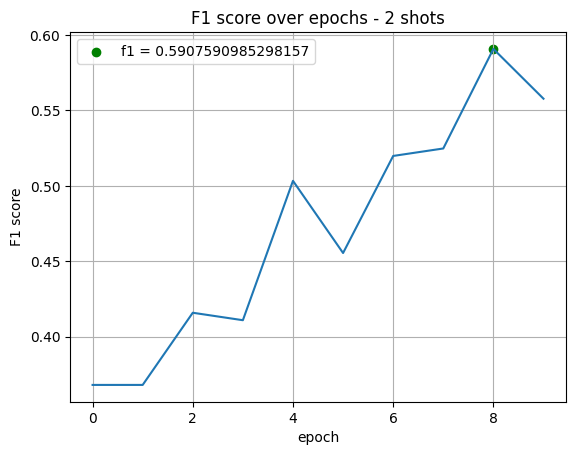

In [95]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix FUNSD - 2 shots')

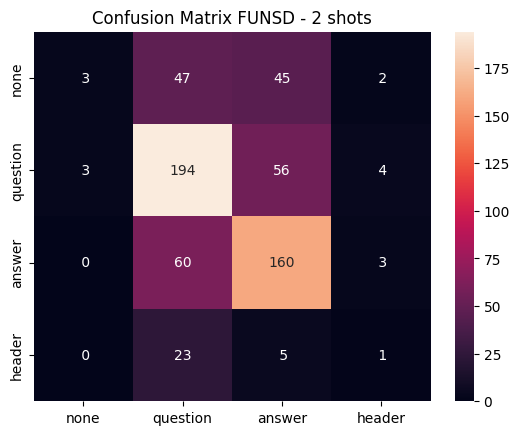

In [96]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")

### 5 shots

In [99]:
n_shots = 5
processed_text, labels = get_processed_text_labels(train_phrases, n_shots)


In [100]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

828it [00:10, 76.79it/s]


In [101]:
processed_text, labels = get_processed_text_labels(test_phrases, n_shots)

test_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

test_dataloader = DataLoader(test_dataset,)

869it [00:11, 77.23it/s]


In [102]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased", cache_dir = '/Data/pedro.silva/')
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-5
)

Epoch 9
f1-score : 0.5363036394119263
tensor([[ 23,  33,  34,   7],
        [ 22, 148,  62,  25],
        [ 34,  36, 150,   3],
        [  1,  18,   6,   4]], device='cuda:0')


In [103]:
def get_y_true(
    input: Dict[str, torch.Tensor],
    inverse_verbalizer : Dict,
    device : str = "cuda",
)-> torch.tensor:
    
    y_true = input['labels']
    y_true = y_true[y_true!= -100].item()
    y_true = inverse_verbalizer[y_true]
    
    return torch.tensor(y_true, device= device)

In [104]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(class2idx)
    )


  0%|          | 0/869 [00:00<?, ?it/s]

100%|██████████| 869/869 [00:07<00:00, 114.38it/s]


In [105]:
f1

tensor(0.4971, device='cuda:0')

In [106]:
multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(class2idx)
)

tensor([[  0,  53,  83,   0],
        [  0, 129,  62,   0],
        [  0, 185, 303,   0],
        [  0,  32,  22,   0]], device='cuda:0')

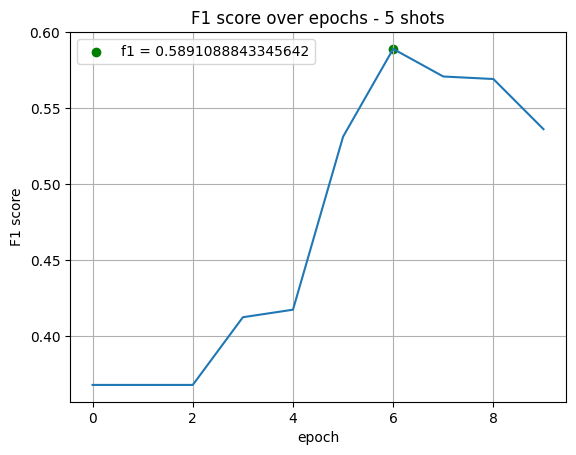

In [107]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix FUNSD - 5 shots')

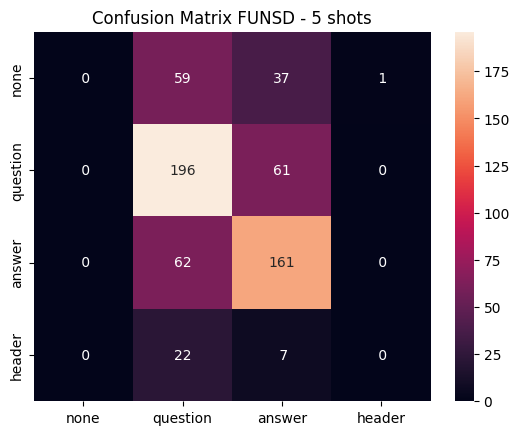

In [108]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")

### 10 shots

In [109]:
n_shots = 10
processed_text, labels = get_processed_text_labels(train_phrases, n_shots)


In [110]:
train_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

train_dataloader = DataLoader(train_dataset,)

1640it [00:19, 83.71it/s]


In [111]:
processed_text, labels = get_processed_text_labels(test_phrases, n_shots)

test_dataset = PETDatasetForClassification(
    processed_text,
    labels,
    tokenizer
)

test_dataloader = DataLoader(test_dataset,)

1637it [00:18, 86.49it/s]


In [112]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased", cache_dir = '/Data/pedro.silva/')
model.to(device)

history, confusion_matrix, best_model = train(
    train_dataloader,
    validation_dataset,
    len(verbalizer),
    model,
    verbalizer,
    tokenizer,
    alpha= 1e-5
)

Epoch 4
f1-score : 0.5891088843345642
tensor([[ 14,  64,  19,   0],
        [  5, 227,  25,   0],
        [  0, 107, 116,   0],
        [  1,  26,   2,   0]], device='cuda:0')


In [ ]:
def get_y_true(
    input: Dict[str, torch.Tensor],
    inverse_verbalizer : Dict,
    device : str = "cuda",
)-> torch.tensor:
    
    y_true = input['labels']
    y_true = y_true[y_true!= -100].item()
    y_true = inverse_verbalizer[y_true]
    
    return torch.tensor(y_true, device= device)

In [ ]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(class2idx)
    )


  0%|          | 0/869 [00:00<?, ?it/s]

100%|██████████| 869/869 [00:07<00:00, 114.38it/s]


In [ ]:
f1

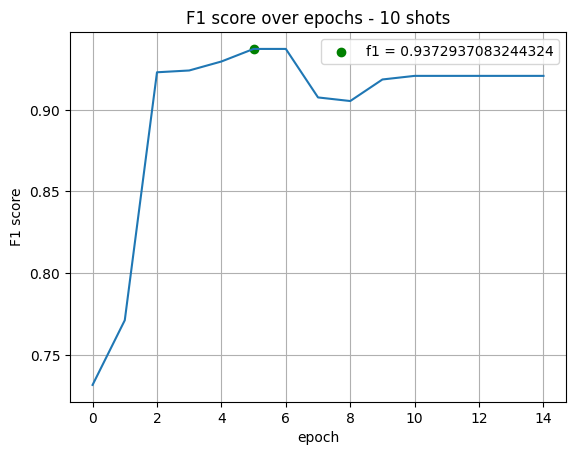

In [ ]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title(f"F1 score over epochs - {n_shots} shots")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix SROIE - 10 shots')

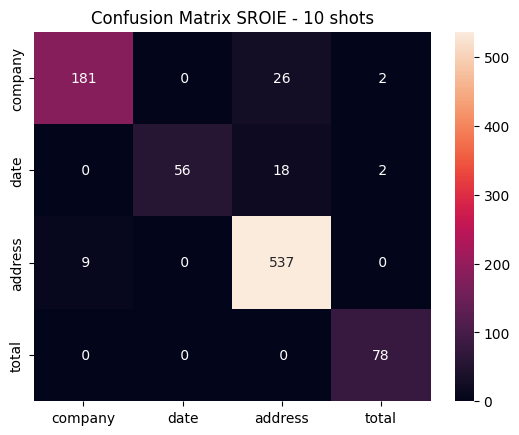

In [ ]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - {n_shots} shots")